In [1]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

## Data and function definition

In [2]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)
select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]

stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
# stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [3]:
x = fits.open(tabfile)


In [4]:
def getspecpaths(tab):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(tab['TELESCOPE'], dtype = str)
    field = np.array(tab['FIELD'], dtype = str)
    sourceid = np.array(tab['APOGEE_ID'], dtype = str)
    length = len(sourceid)
    path = tuple((specdir + specname).format(TELESCOPE = telescope[i], FIELD = field[i], SOURCEID = sourceid[i]) 
                 for i in range(length))
    return path

def getapstarpath(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    return path
    

def getwavs(hdulist):
    header = hdulist[1].header
    CRVAL1 = header['CRVAL1']
    CDELT1 = header['CDELT1']
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(hdulist[1].data)))
    return wavs 

def getspec(path):
    hdulist = fits.open(path)
    spectrum = hdulist[1].data
    model = hdulist[3].data
    wavs = getwavs(hdulist)
    return (spectrum, model, wavs)

## Binning visualizations

In [5]:
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']

CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
print('CA Cloud Stars:',  len(CA_inds))

CA_stars = stars[CA_inds]



CA Cloud Stars: 1116


/uufs/chpc.utah.edu/sys/srcdir/pylib/3.6.3/biokevlar/biokevlar-0.7/.eggs/matplotlib-3.3.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


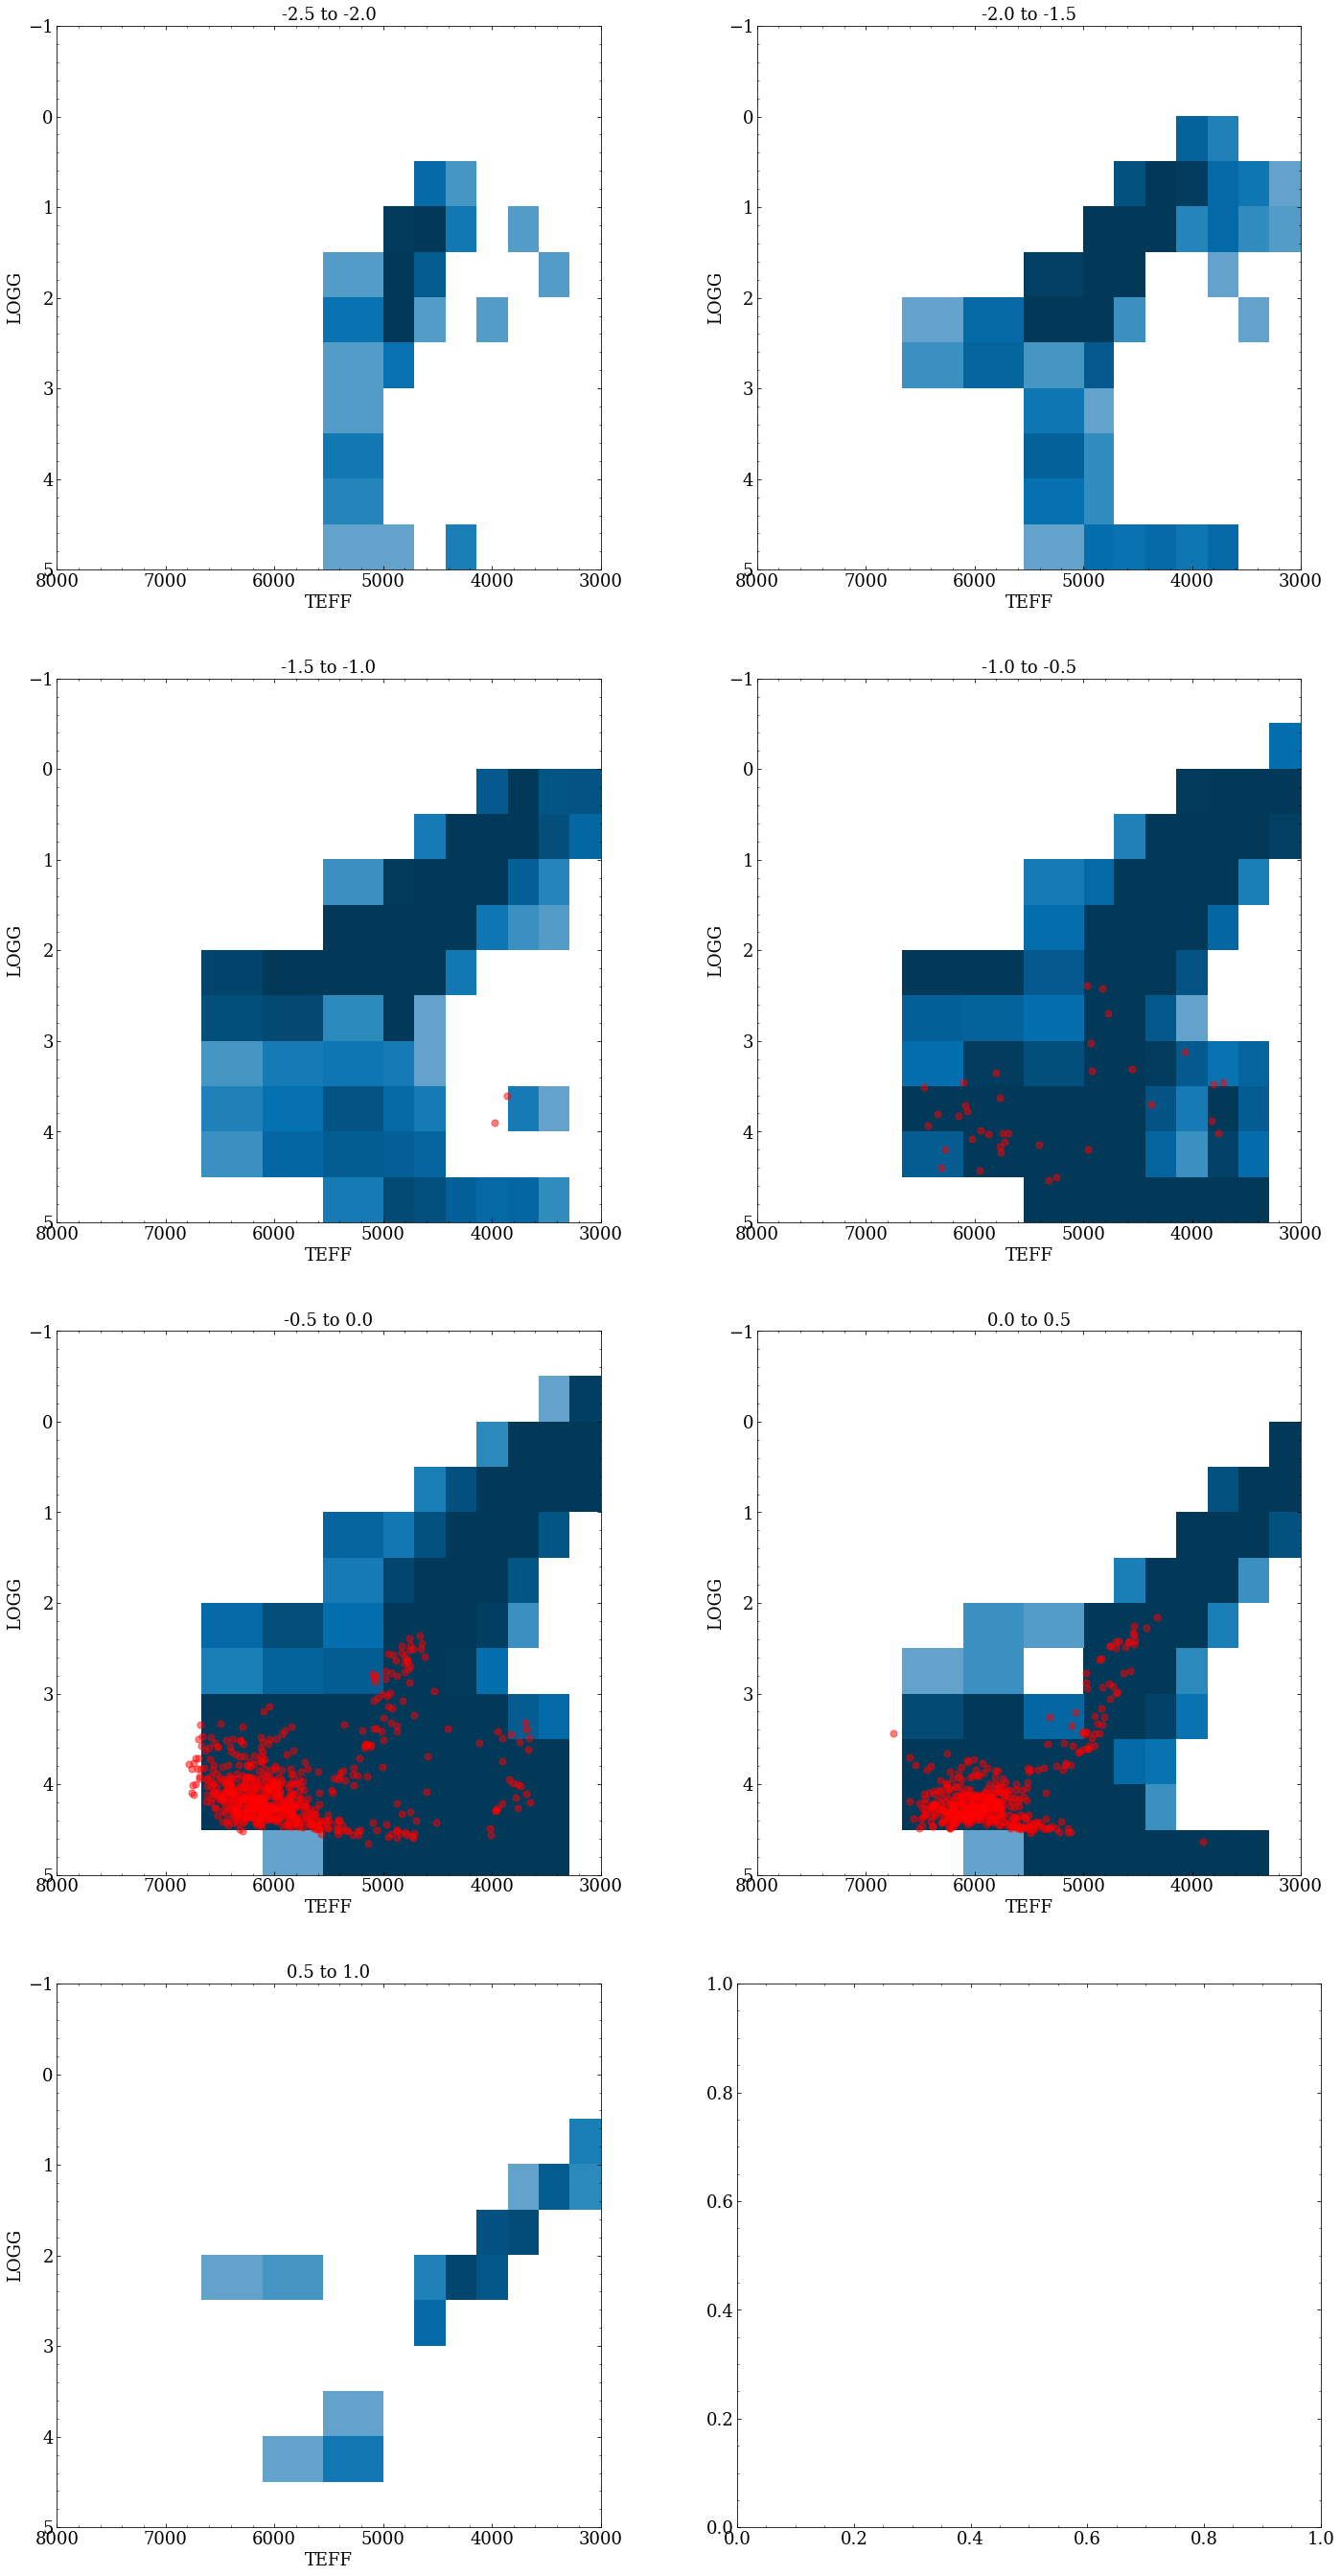

In [6]:
binmin, binmax = (2000, 8000)

fig, axs = plt.subplots(4,2, figsize = (24,48))

# teffbins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
# loggbins = np.arange(-1, 5.2, 0.2)

teffbins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
loggbins = np.arange(-1, 5.1, 0.5)    

def hr_hist_bins(ax, tab, fig = fig, teffbins = teffbins, loggbins = loggbins):
    binmin, binmax = (np.min(teffbins), np.max(teffbins))
    binmin_, binmax_ = (np.min(loggbins), np.max(loggbins))
    binsize = np.array([teffbins,loggbins])
    histrange = (teffbins, loggbins)
    hist = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = binsize)[0]
    hist[np.where(hist < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)
    
#     image = ax.imshow(hist.T[:, -1:0:-1], cmap = 'PuBu', extent = (binmax,binmin, binmax_,binmin_), vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
        
    
    bins1 = np.concatenate([np.arange(3000, 5000, 250), [5000]])
    bins2 = np.concatenate([np.arange(5000,10000, 500), [10000]])
    hist1 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins1, loggbins))[0]
    hist1[np.where(hist1 < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)


    image1 = ax.imshow(hist1.T[:, -1:0:-1], cmap = 'PuBu', extent = (5000,3000, 5,-1), norm = norm)#, vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
    hist2 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins2, loggbins))[0]
    hist2[np.where(hist2 < 4)] = np.nan
    image2 = ax.imshow(hist2.T[:, -1:0:-1], cmap = 'PuBu', extent = (10000,5000, 5,-1), norm = norm)# vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)

    
        
    ax.set_aspect((8000 - binmin) / 6)
#     fig.colorbar(image, ax = ax, label = 'Binned Stars',fraction=0.046)
    ax.set_xlim(8000, binmin)
    ax.set_ylim(binmax_, binmin_)
#     ax.set_xticks(np.arange(binmax, binmin, -1000))
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')

def plot_hr(ax, tab, fig = fig):
    ax.scatter(tab['TEFF'], tab['LOGG'], color = 'r', s= 50, alpha = 0.5)

# fig.subplots_adjust(hspace=0.5)
m_h_bins = np.arange(-2.5, 1.1, .5)
for i in range(4):
    for j in range(2):
        if (i==3) & (j==1):
            break
        stars_restricted = stars[np.where((stars['M_H'] > m_h_bins[2*i+j]) & (stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
#         hr_hist(axs[i, j], stars_restricted)
#         hr_hist_bins(axs[i,j], stars_restricted, teffbins = teffbins, loggbins = loggbins)
        axs[i,j].set_title(str(round(m_h_bins[2*i+j],1))+  ' to ' + str(round(m_h_bins[2*i+j+1],1)))
        
        
        CA_stars_restricted = CA_stars[np.where((CA_stars['M_H'] > m_h_bins[2*i+j]) & (CA_stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
        hr_hist_bins(axs[i,j], stars_restricted)
        plot_hr(axs[i, j], CA_stars_restricted)
# hr_hist(axs[0,0], stars)
# hr_hist(axs[0,1], stars)
# hr_hist(axs[1,0], stars)
# hr_hist(axs[1,1], stars)
plt.show()

## Residuals
### Bitmasks

In [7]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

def create_errmask(err, threshold = 2):
    med = np.repeat(np.nanmedian(err, axis = -1), err.shape[-1]).reshape(err.shape)
    mask = np.zeros(err.shape)
    mask[err > threshold * med] = 1
    return mask

def create_countmask(mask, count = 5):
#     print(mask.shape)
    n_remaining = np.repeat(len(mask) - np.sum(mask, axis = 0), len(mask)).reshape(mask.shape)
#     print(n_remaining.shape)
    mask = np.zeros(mask.shape)
    mask[n_remaining < count] = 1
    return mask

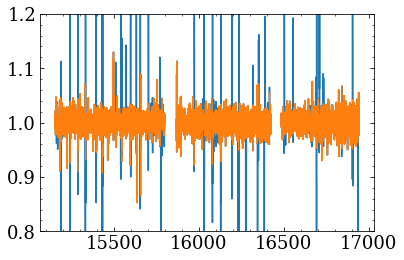

In [8]:
i = 2000
startest = stars[i:i+1]
hdulist1 = fits.open(getspecpaths(startest)[0])
bitmask = fits.open(getapstarpath(hdulist1))[3].data[0,:]
# mask = (np.bitwise_and(bitmask,11) == 1).astype(int) + (np.bitwise_and(bitmask, 13) == 1).astype(int) + (np.bitwise_and(bitmask, 14) == 1).astype(int)
# print(bitmask)
mask = create_mask(bitmask, skipflags = [10, 11]) #11 causes big gaps in the data - skipping medium and low persistence


fig = plt.figure()
ax = plt.subplot()
def quickplot(hdulist, ax, mask = None, lims = None):
    wavs = getwavs(hdulist)
    spec = hdulist[1].data
    mod = hdulist[3].data
    if mask is not None:
        wavs = ma.array(wavs, mask = mask)
        spec = ma.array(spec,mask = mask)
        mod = ma.array(mod, mask = mask)
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        res = np.divide(spec,mod)
    
    ax.plot(wavs, res)
    ax.set_ylim(.8, 1.2)
    
quickplot(hdulist1, ax)# mask = bitmask)
quickplot(hdulist1, ax, mask = mask)
plt.show()

0.011165140196681023


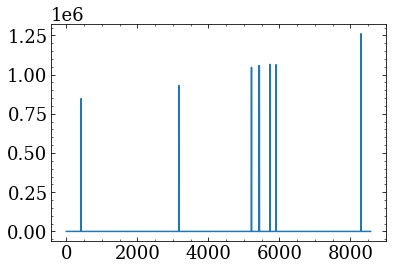

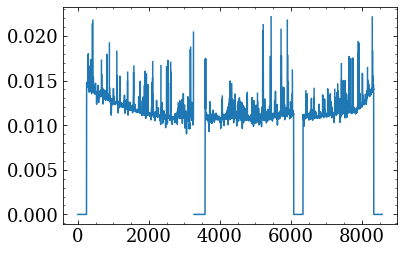

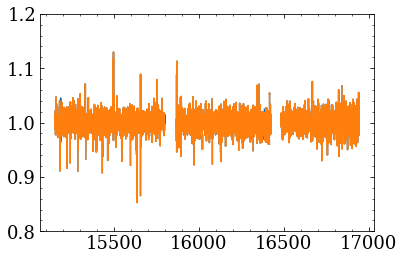

In [9]:
plt.plot(hdulist1[2].data)
print(np.median(hdulist1[2].data))
plt.show()

dat = hdulist1[2].data
m = np.zeros(len(dat))
m[np.where(dat > 2 * np.nanmedian(dat))[0]] = 1
dat_m = ma.array(dat, mask = m)
plt.plot(dat_m)
plt.show()

# fig, axs = plt.subplots(2,1)
# ax = axs[0]
fig = plt.figure()
ax = plt.subplot()
mask_errs = create_errmask(hdulist1[2].data, threshold = 2)
mask_ = mask + mask_errs
# quickplot(hdulist1, ax)
quickplot(hdulist1, ax, mask = mask)
quickplot(hdulist1, ax, mask = mask_)
plt.show()

In [10]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.arange(-1, 5.2, 0.2)
m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])

# teff_bins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
# logg_bins = np.arange(-1, 5.1, 0.5)
# m_h_bins = np.concatenate([np.arange(-2.5, 1.0, .3), [1]])

# CA_stars['RES_STD'] = np.empty(len(CA_stars))
# CA_stars['BINNED'] = np.zeros(len(CA_stars))

# teff_bins = np.append(np.arange(3000, 10000, 2000), np.arange(10000, 22000, 2000))
# print(len(teff_bins))
# logg_bins = np.arange(0, 5, 0.5)
# print(len(logg_bins))
# m_h_bins = np.arange(-2.5, 1, 0.5)
# print(len(m_h_bins))

In [31]:
def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin, return_indices = False):
    with np.errstate(divide='ignore', invalid = 'ignore'):
        indices = np.where((tab['TEFF'] > teff_bin[0]) & (tab['TEFF'] < teff_bin[1]) & 
                            (tab['LOGG'] > logg_bin[0]) & (tab['LOGG'] < logg_bin[1]) & 
                            (tab['M_H'] > m_h_bin[0]) & (tab['M_H'] < m_h_bin[1]))[0]
    if return_indices:
        return indices
    else:
        return tab[indices]
    
# header = fits.Header()
# header['COMMENT'] = 'Generated ' + str(datetime.datetime.now())
# data_hdus = [fits.PrimaryHDU(header = header)]

datname = getspecpaths(stars[:1])[0]
dat = fits.open(datname)
header = dat[1].header
CRVAL1 = header['CRVAL1']
CDELT1 = header['CDELT1']
length = len(dat[1].data)
dat.close()

for i in tqdm(range(len(teff_bins)-1), total = len(teff_bins)):
    header = fits.Header()
    header['COMMENT'] = 'Generated ' + str(datetime.datetime.now())
    data_hdus = [fits.PrimaryHDU(header = header)]
    
    teff_bin = (teff_bins[i], teff_bins[i+1])
    
    for j in range(len(logg_bins)-1):
        logg_bin = (logg_bins[j], logg_bins[j+1])
        for k in range(len(m_h_bins)-1):
            m_h_bin = (m_h_bins[k], m_h_bins[k+1])
            
            selected_i = get_selected_stars(stars, teff_bin, logg_bin, m_h_bin, return_indices = True)
            select = stars[selected_i]
            
            
            stars_names = getspecpaths(select)
    
            nstars = len(stars_names)
            if nstars > 5:
                print('bin', teff_bin, logg_bin, m_h_bin, 'stars in bin', len(stars_names))
                
                hdus = tuple(fits.open(name) for name in stars_names)
                
                spectra = np.zeros((nstars, length))
                models = np.zeros((nstars, length))
                bitmask = np.zeros((nstars, length))
                
                for ind in range(len(stars_names)):
                    name = stars_names[ind]
                    hdul = fits.open(name)
                    spectra[ind, :] = hdul[1].data
                    models[ind, :] = hdul[3].data
                    
                    apStar = fits.open(getapstarpath(hdul))
                    bitmask[ind, :] = apStar[3].data[0,:]
                    bitmask = bitmask.astype(int)
                    
                    hdul.close()
                    apStar.close()
                    
                # Create mask array, starting with bitmasks
#                 apStar = tuple(getapstarpath(hdu_) for hdu_ in hdus)
#                 bitmask = np.array(tuple(fits.open(name)[3].data[0,:] for name in apStar))
                mask = create_mask(bitmask, skipflags = [10,11]).astype(int)
                # Now add a mask for the apscapStar errors
                errors = np.array(tuple(hdu[2].data for hdu in hdus))
                mask = mask + create_errmask(errors, threshold = 1.8)
                mask = mask.astype(bool)
                # Now create a separate mask for the where the number statistics might be bad
                count_mask = create_countmask(mask)
#                 mask = (mask + count_mask).astype(bool)
                
                
                
#                 mask = np.zeros(mask.shape)
                
                spectra = ma.array(spectra, mask = mask)
                models = ma.array(models, mask = mask)
            
#                 for hdu in hdus: #hopefully clear up some space!
#                     hdu.close()
                
                with np.errstate(divide='ignore', invalid = 'ignore'):
                    residuals = spectra / models
                    
                residuals_median, resstd = (ma.median(residuals, axis = 0), ma.std(residuals, ddof = 1, axis = 0))
                
#                 stars['RES_STD'][selected_i] = ma.mean(resstd)
                
                wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(residuals_median)))

                

#                 errmedian = np.median(errors)
#                 fig, axs = plt.subplots(2,1, figsize = (12,8), sharex = True, gridspec_kw = {'height_ratios':(0.75, 0.25)})
#                 ax, errax = tuple(axs)
#                 for row in range(len(residuals)):
#                     ax.plot(wavs, residuals[row,:].data, linestyle = 'dashed', linewidth = 0.2)
#                     errax.plot(wavs, errors[row,:].data, linestyle = 'dashed', linewidth = 0.8)
#                 ax.plot(wavs, residuals_median, linewidth = 0.8, color = 'k')
#                 ax.set_xlim(15250, 15500)
#                 ax.set_ylim(.8, 1.2)
#                 errax.set_ylim(0, 5 * errmedian)
#                 ax.set_ylabel('Residual')
#                 errax.set_xlabel('Wavelength ($\circ{A}$)')
#                 errax.set_ylabel('Spectra Err')
#                 plt.show()
                
        
                
#                  header = fits.Header()
#                 header['NBIN'] = nstars
#                 header['CRVAL1'] = CRVAL1
#                 header['CDELT1'] = CDELT1
#                 header['COMMENT'] = 'BINBORDERS: TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin)  + ' M_H ' + str(m_h_bin)
#                 primaryhdu = fits.PrimaryHDU(header = header)
                h = fits.ImageHDU(data = np.array([residuals_median.data, resstd.data, count_mask[0,:]]))
                h.header['NBIN'] = nstars
                h.header['TMIN'] = teff_bin[0]
                h.header['TMAX'] = teff_bin[1]
                h.header['GMIN'] = logg_bin[0]
                h.header['GMAX'] = logg_bin[1]
                h.header['MMIN'] = m_h_bin[0]
                h.header['MMAX'] = m_h_bin[1]
                h.header['CRVAL1'] = CRVAL1
                h.header['CDELT1'] = CDELT1
                
                
#                 hdul = fits.HDUList([primaryhdu, residualhdu, errhdu])
#                 fname = 'residual_CA_' + str(i) + '_' + str(j) + '_'+ str(k) + '.fits'
            else:
                h = fits.ImageHDU()
                h.header['NBIN'] = 0
                h.header['TMIN'] = teff_bin[0]
                h.header['TMAX'] = teff_bin[1]
                h.header['GMIN'] = logg_bin[0]
                h.header['GMAX'] = logg_bin[1]
                h.header['MMIN'] = m_h_bin[0]
                h.header['MMAX'] = m_h_bin[1]
                h.header['CRVAL1'] = None
                h.header['CDELT1'] = None
                
            
            data_hdus.append(h)
            
    data_hdus = fits.HDUList(data_hdus)
    data_hdus.writeto('ResidualsFiles/remake/Residuals_teffbin{low}-{high}.fits'.format(low=teff_bin[0], 
                                                                                 high =teff_bin[1]), overwrite = True)
    
    
#                 hduout.header = headers[0]
#                 hduout.header.set('BINBORDERS', 'TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin) + ' M_H ' + str(m_h_bin))
#                 hdul.writeto('StellarResidualsSpring2022/ResidualsFiles/CACLOUD/' + fname, overwrite = True)
                
                
#"""
            




  3%|▎         | 2/75 [00:04<02:56,  2.42s/it]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/tqdm-4.19.4-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  4%|▍         | 3/75 [00:07<02:52,  2.40s/it]

bin (3150, 3200) (-2.220446049250313e-16, 0.19999999999999973) (-0.10000000000000031, 0.09999999999999964) stars in bin 22
bin (3150, 3200) (0.19999999999999973, 0.3999999999999997) (-0.10000000000000031, 0.09999999999999964) stars in bin 7
bin (3150, 3200) (0.19999999999999973, 0.3999999999999997) (0.09999999999999964, 0.2999999999999996) stars in bin 30
bin (3150, 3200) (0.3999999999999997, 0.5999999999999996) (0.09999999999999964, 0.2999999999999996) stars in bin 15


  5%|▌         | 4/75 [00:13<04:01,  3.40s/it]

bin (3200, 3250) (-0.20000000000000018, -2.220446049250313e-16) (-0.5000000000000002, -0.30000000000000027) stars in bin 8
bin (3200, 3250) (-0.20000000000000018, -2.220446049250313e-16) (-0.30000000000000027, -0.10000000000000031) stars in bin 35
bin (3200, 3250) (-2.220446049250313e-16, 0.19999999999999973) (-0.5000000000000002, -0.30000000000000027) stars in bin 11
bin (3200, 3250) (-2.220446049250313e-16, 0.19999999999999973) (-0.30000000000000027, -0.10000000000000031) stars in bin 34
bin (3200, 3250) (-2.220446049250313e-16, 0.19999999999999973) (-0.10000000000000031, 0.09999999999999964) stars in bin 97
bin (3200, 3250) (0.19999999999999973, 0.3999999999999997) (-0.10000000000000031, 0.09999999999999964) stars in bin 68
bin (3200, 3250) (0.19999999999999973, 0.3999999999999997) (0.09999999999999964, 0.2999999999999996) stars in bin 117
bin (3200, 3250) (0.3999999999999997, 0.5999999999999996) (-0.10000000000000031, 0.09999999999999964) stars in bin 10
bin (3200, 3250) (0.3999999

  7%|▋         | 5/75 [00:50<11:51, 10.16s/it]

bin (3250, 3300) (-0.20000000000000018, -2.220446049250313e-16) (-0.5000000000000002, -0.30000000000000027) stars in bin 12
bin (3250, 3300) (-0.20000000000000018, -2.220446049250313e-16) (-0.30000000000000027, -0.10000000000000031) stars in bin 17
bin (3250, 3300) (-2.220446049250313e-16, 0.19999999999999973) (-0.5000000000000002, -0.30000000000000027) stars in bin 21
bin (3250, 3300) (-2.220446049250313e-16, 0.19999999999999973) (-0.30000000000000027, -0.10000000000000031) stars in bin 67
bin (3250, 3300) (-2.220446049250313e-16, 0.19999999999999973) (-0.10000000000000031, 0.09999999999999964) stars in bin 43
bin (3250, 3300) (0.19999999999999973, 0.3999999999999997) (-0.5000000000000002, -0.30000000000000027) stars in bin 9
bin (3250, 3300) (0.19999999999999973, 0.3999999999999997) (-0.30000000000000027, -0.10000000000000031) stars in bin 25
bin (3250, 3300) (0.19999999999999973, 0.3999999999999997) (-0.10000000000000031, 0.09999999999999964) stars in bin 128
bin (3250, 3300) (0.199

  8%|▊         | 6/75 [02:01<23:11, 20.17s/it]

bin (3300, 3350) (-0.20000000000000018, -2.220446049250313e-16) (-0.5000000000000002, -0.30000000000000027) stars in bin 15


KeyboardInterrupt: 

In [ ]:
# data_hdus = fits.HDUList(data_hdus)
# data_hdus.writeto('ResidualsFiles/TEST_Residuals.fits', overwrite = True)

In [28]:
np.bitwise_and(np.array([[0, 0], [0,0]]), 2)

array([[0, 0],
       [0, 0]])

/uufs/chpc.utah.edu/sys/srcdir/pylib/3.6.3/biokevlar/biokevlar-0.7/.eggs/matplotlib-3.3.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


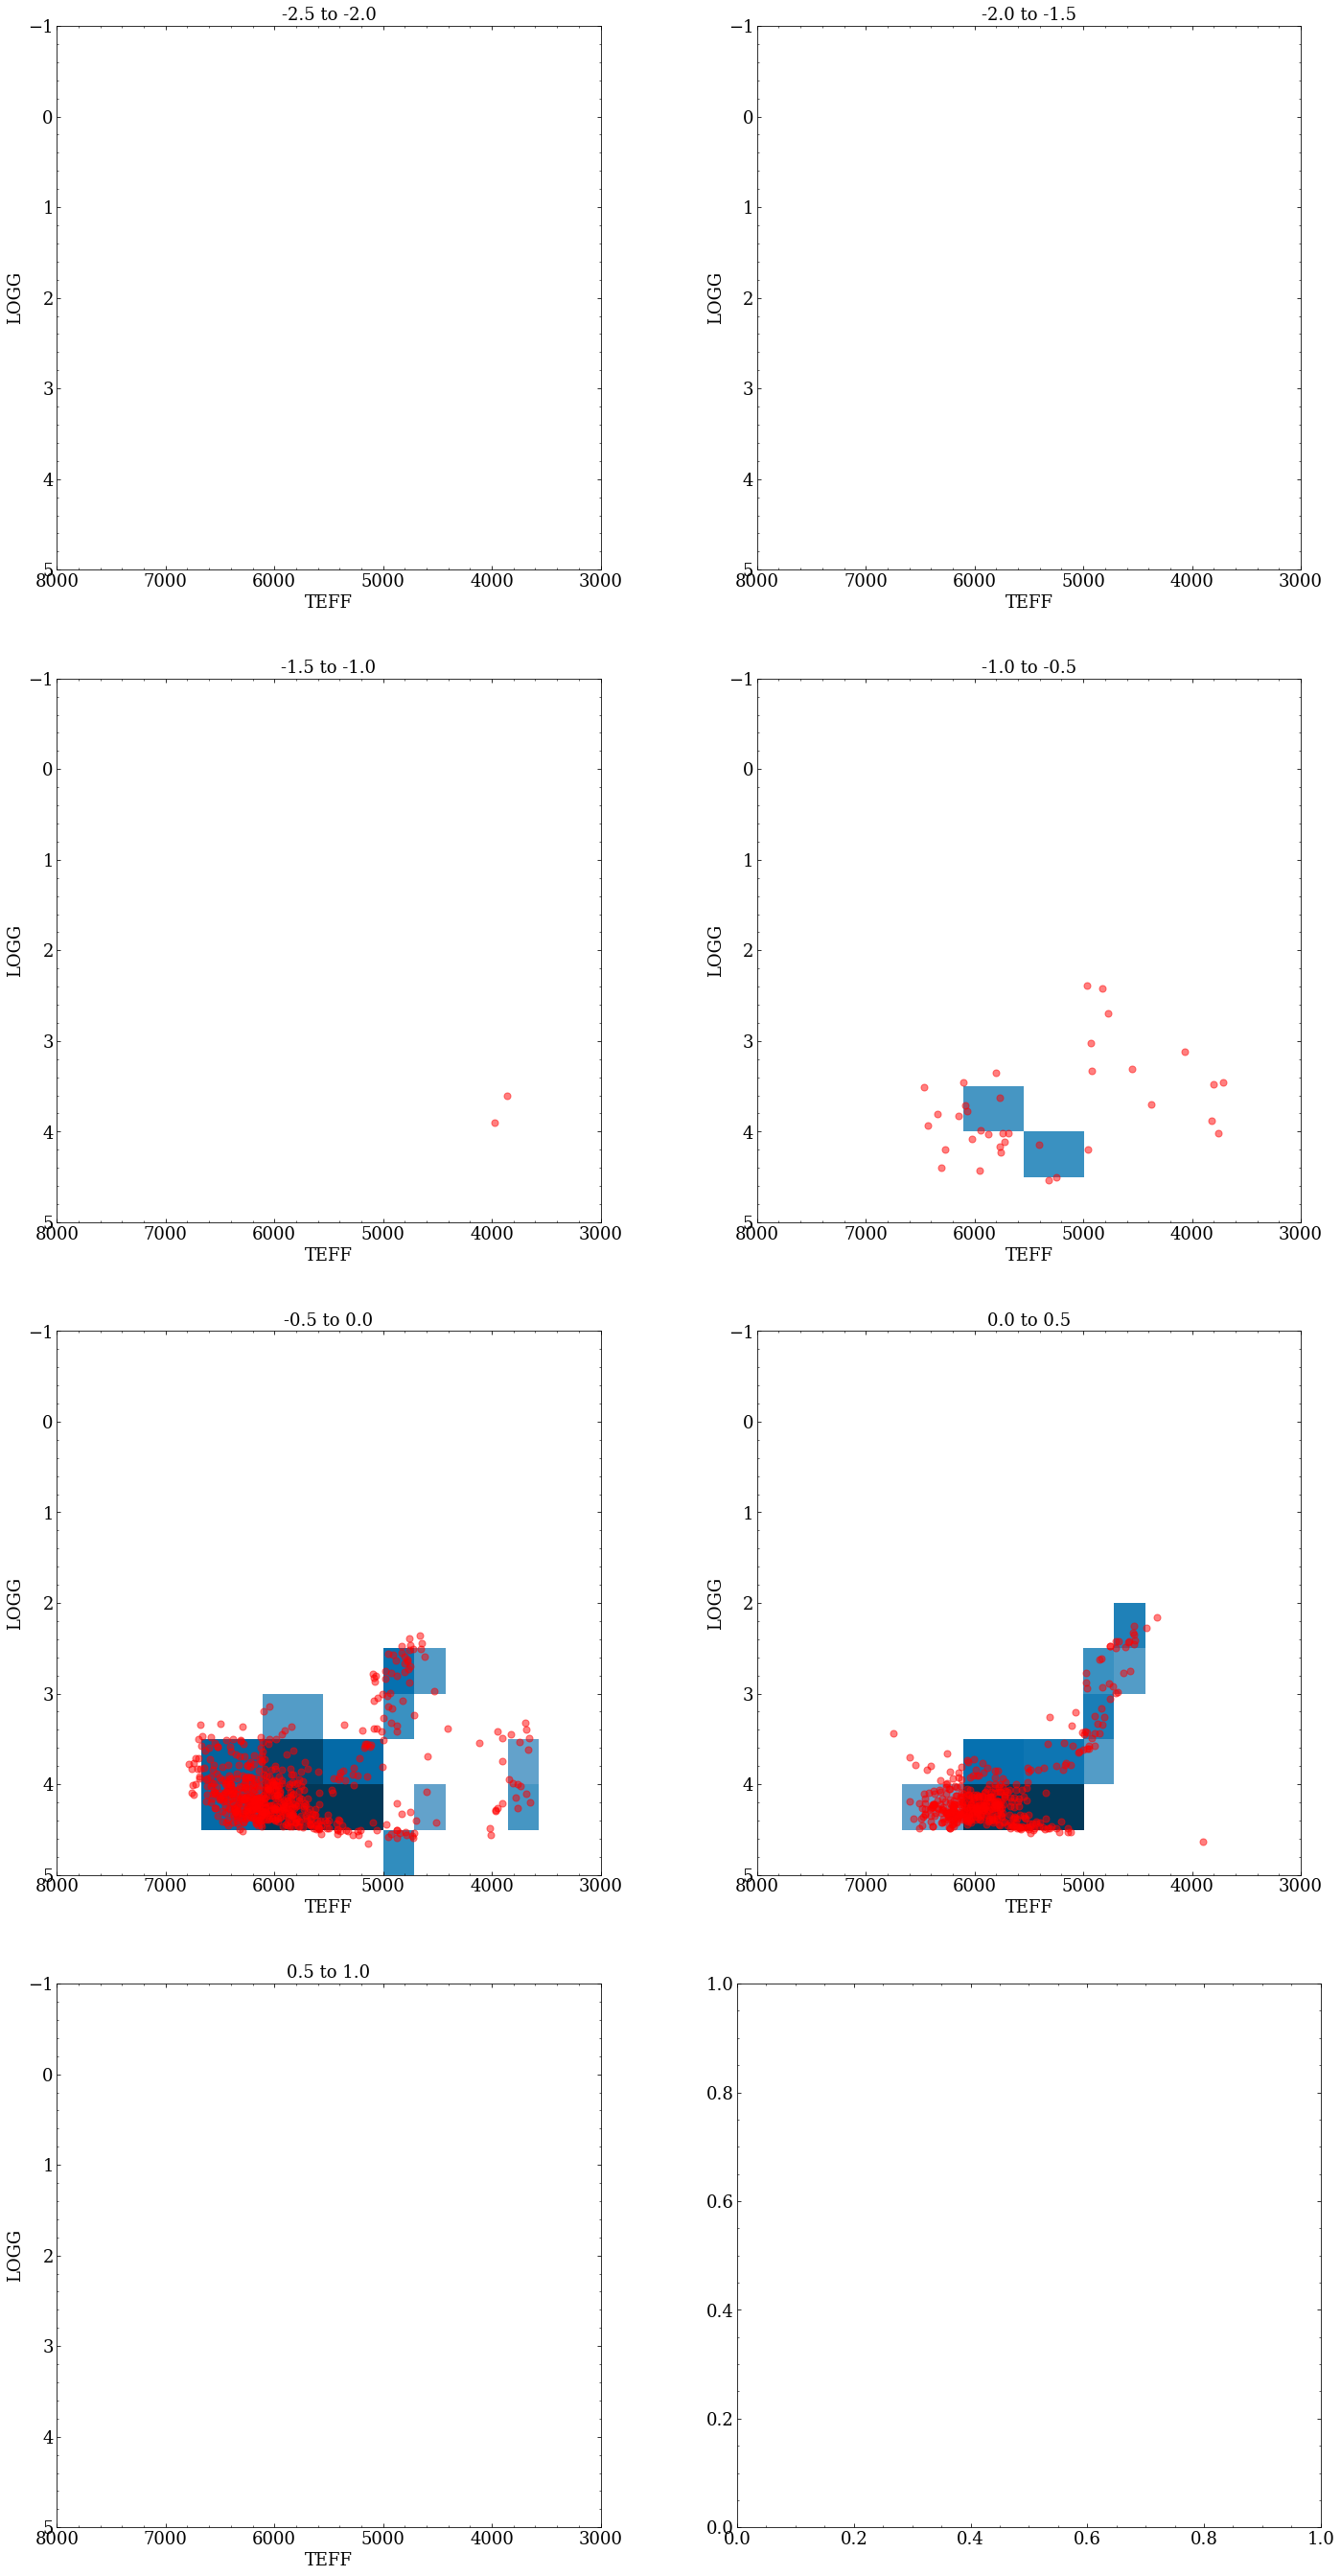

In [176]:

fig, axs = plt.subplots(4,2, figsize = (24,48))



def hr_std_hist(ax, tab, fig = fig, teffbins = teff_bins, loggbins = logg_bins):
    binmin, binmax = (np.min(teffbins), np.max(teffbins))
    binmin_, binmax_ = (np.min(loggbins), np.max(loggbins))
    binsize = np.array([teffbins,loggbins])
    histrange = (teffbins, loggbins)
    hist = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = binsize)[0]
    hist[np.where(hist < 4)] = np.nan
#     norm = colors.LogNorm(vmin = 0.1, vmax = 100)
    
#     image = ax.imshow(hist.T[:, -1:0:-1], cmap = 'PuBu', extent = (binmax,binmin, binmax_,binmin_), vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
        
    
    bins1 = np.concatenate([np.arange(3000, 5000, 250), [5000]])
    bins2 = np.concatenate([np.arange(5000,10000, 500), [10000]])
    hist1 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins1, loggbins))[0]
    hist1[np.where(hist1 < 5)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)


#     image1 = ax.imshow(hist1.T[:, -1:0:-1], cmap = 'PuBu', extent = (5000,3000, 5,-1), norm = norm)#, vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
    image1 = ax.imshow()
    hist2 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins2, loggbins))[0]
    hist2[np.where(hist2 < 5)] = np.nan
    image2 = ax.imshow(hist2.T[:, -1:0:-1], cmap = 'PuBu', extent = (10000,5000, 5,-1), norm = norm)# vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)

    
        
    ax.set_aspect((8000 - binmin) / 6)
#     fig.colorbar(image, ax = ax, label = 'Binned Stars',fraction=0.046)
    ax.set_xlim(8000, binmin)
    ax.set_ylim(binmax_, binmin_)
#     ax.set_xticks(np.arange(binmax, binmin, -1000))
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')

def plot_hr(ax, tab, fig = fig):
    ax.scatter(tab['TEFF'], tab['LOGG'], color = 'r', s= 50, alpha = 0.5)

# fig.subplots_adjust(hspace=0.5)
m_h_bins = np.arange(-2.5, 1.1, .5)
for i in range(4):
    for j in range(2):
        if (i==3) & (j==1):
            break
        stars_restricted = stars[np.where((stars['M_H'] > m_h_bins[2*i+j]) & (stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
#         hr_hist(axs[i, j], stars_restricted)
#         hr_hist_bins(axs[i,j], stars_restricted, teffbins = teffbins, loggbins = loggbins)
        axs[i,j].set_title(str(round(m_h_bins[2*i+j],1))+  ' to ' + str(round(m_h_bins[2*i+j+1],1)))
        
        
        CA_stars_restricted = CA_stars[np.where((CA_stars['M_H'] > m_h_bins[2*i+j]) & (CA_stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
        hr_hist_bins(axs[i,j], CA_stars_restricted)
        plot_hr(axs[i, j], CA_stars_restricted)
# hr_hist(axs[0,0], stars)
# hr_hist(axs[0,1], stars)
# hr_hist(axs[1,0], stars)
# hr_hist(axs[1,1], stars)
plt.show()

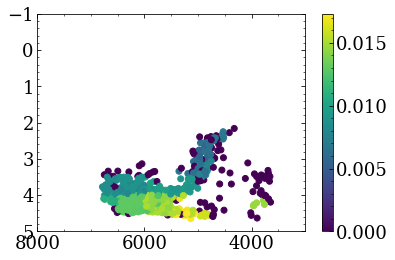

In [90]:
fig = plt.figure()
ax = plt.subplot()
points = ax.scatter(CA_stars['TEFF'], CA_stars['LOGG'], c= CA_stars['RES_STD'])
fig.colorbar(points, ax = ax)
ax.set_xlim(8000, 3000)
ax.set_ylim(5,-1)
plt.show()

In [ ]:
#scipy 

In [ ]:
# PLOTS TO MAKE
# Residuals at set temperature, stepping down in m_h
#  Possibly here also include residual errors as shaded region surrounding
# Other bin stuff? the bins are my big hangup right now asdfdsaf


In [125]:
x = np.array([0,1,2,3])
y = np.array([4,5,6,7])
no = np.array([])

In [135]:
header = fits.Header()
header['NBIN'] = nstars
header['CRVAL1'] = CRVAL1
header['CDELT1'] = CDELT1
# header['COMMENT'] = 'BINBORDERS: TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin)  + ' M_H ' + str(m_h_bin)
primaryhdu = fits.PrimaryHDU(header = header)
h1 = fits.BinTableHDU(Table({'one': x, 'two':y}))
h2 = fits.BinTableHDU(Table({'three': x, 'four': y}))
h3 = fits.BinTableHDU(Table(no))
hdulist_ = fits.HDUList([h1, h2, h3])

# hdulist_ = fits.HDUList([primaryhdu, residualhdu, errhdu])
# fname = 'residual_CA_' + str(i) + '_' + str(j) + '_'+ str(k) + '.fits'



In [149]:
aa=fits.BinTableHDU()
aa.header['a'] = 'hello'

In [150]:
aa.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    0 / length of dimension 1                          
NAXIS2  =                    0 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    0 / number of table fields                         
A       = 'hello   '                                                            